In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras import Model
import tensorflow as tf

In [4]:
image_names= os.listdir("./train")
mask_names= os.listdir("./train_masks")

In [5]:
image_names.sort()
mask_names.sort()

In [6]:
rel_image= []
rel_mask= []

In [7]:
for i in image_names:
    
    p= os.path.join("./train", i)
    rel_image.append(p)
    
for i in mask_names:
    
    p= os.path.join("./train_masks", i)
    rel_mask.append(p)

In [8]:
def load_data(data_path):
    
    images= []
    
    for i in data_path:
        x= Image.open(i)
        x= x.resize((256, 256))
        x= np.array(x)
        images.append(x)
        
    images= np.array(images)
    print("Done")
    return images

In [9]:
x_train= load_data(rel_image[:2000])
y_train= load_data(rel_mask[: 2000])
x_test= load_data(rel_image[2000: 2200])
y_test= load_data(rel_mask[2000: 2200])

Done
Done
Done
Done


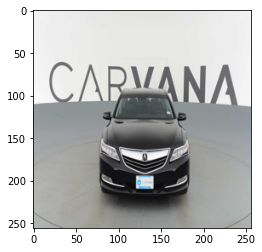

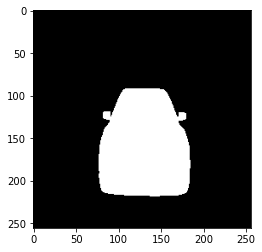

In [10]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(y_train[0], cmap= "gray")
plt.show()

In [11]:
y_test.shape

(200, 256, 256)

In [12]:
y_train= y_train.reshape((2000, 256, 256, 1))
y_test= y_test.reshape((200, 256, 256, 1))

In [13]:
y_test.shape, y_train.shape

((200, 256, 256, 1), (2000, 256, 256, 1))

## Model Building

In [14]:
def build_unet(shape):
    input_layer = Input(shape = shape)
    
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_layer)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(conv5), conv4], axis = 3)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up6)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(conv6), conv3], axis = 3)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(up7)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv7), conv2], axis = 3)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up8)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv8), conv1], axis = 3)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up9)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)
    
    return Model(input_layer, conv10)

In [15]:
model= build_unet((256, 256, 3))

In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [17]:
model.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])

In [18]:
batchSize= 64
h = model.fit(x_train, y_train, epochs= 10, batch_size= batchSize, validation_data= (x_test, y_test))

Epoch 1/10
32/32 [==============================] - 18s 559ms/step - loss: 3.4327 - acc: 0.7530 - val_loss: 0.4274 - val_acc: 0.8429
Epoch 2/10
32/32 [==============================] - 16s 509ms/step - loss: 0.3833 - acc: 0.8565 - val_loss: 0.4377 - val_acc: 0.8521
Epoch 3/10
32/32 [==============================] - 16s 508ms/step - loss: 0.3691 - acc: 0.8699 - val_loss: 0.3010 - val_acc: 0.8804
Epoch 4/10
32/32 [==============================] - 16s 507ms/step - loss: 0.2894 - acc: 0.8899 - val_loss: 0.1622 - val_acc: 0.9357
Epoch 5/10
32/32 [==============================] - 16s 508ms/step - loss: 0.1264 - acc: 0.9501 - val_loss: 0.0986 - val_acc: 0.9622
Epoch 6/10
32/32 [==============================] - 16s 509ms/step - loss: 0.1116 - acc: 0.9592 - val_loss: 0.1090 - val_acc: 0.9575
Epoch 7/10
32/32 [==============================] - 16s 508ms/step - loss: 0.0898 - acc: 0.9653 - val_loss: 0.0789 - val_acc: 0.9683
Epoch 8/10
32/32 [==============================] - 16s 508ms/step - 

In [19]:
def load_image(image_name):
    
    img= Image.open(image_name)
    img= img.resize((256, 256))
    img= np.array(img)
    
    return img

In [20]:
test_img= load_image(rel_image[3406])
actual_mask= load_image(rel_mask[3406])

In [21]:
img= test_img.reshape((1, 256, 256, 3))

In [22]:
pred= model.predict(img)

In [23]:
def plotting(img, title, gray= True):
    
    if gray== True:
        plt.imshow(img[0, : , :, 0], cmap= "gray")
        plt.title(title)
        plt.show()
        
    else:
        plt.imshow(img)
        plt.title(title)
        plt.show()

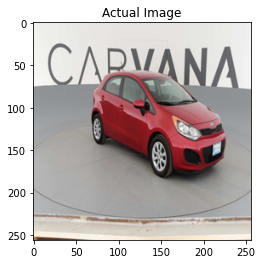

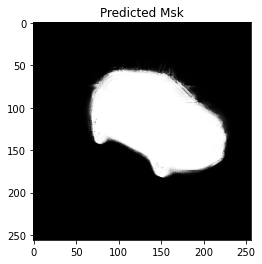

Text(0.5, 1.0, 'Actual Mask')

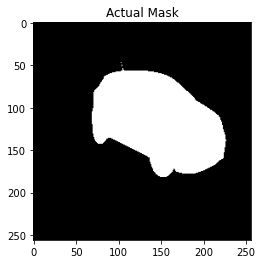

In [24]:
plotting(test_img, "Actual Image", False)
plotting(pred, "Predicted Msk")
plt.imshow(actual_mask, cmap= "gray")
plt.title("Actual Mask")